In [106]:
import os
import sys
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL 
from PIL import Image

sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/src/')
sys.path.append('/Users/trimchala/BreastPathQ/breastpathq/src/rle_utils')
dataset_base_path = '/Users/trimchala/BreastPathQ/breastpathq/datasets/datasciencebowl2018_nuclei'
train_path = os.path.join(dataset_base_path, 'stage1_train')

image_file_df = pd.DataFrame(glob(os.path.join(train_path, "*", "images", "*.png")), columns=['image_file'])
image_file_df['ImageId'] = image_file_df['image_file'].apply(
    lambda x: os.path.splitext(os.path.basename(x))[0]
)

mask_file_df = pd.DataFrame(glob(os.path.join(train_path, "*", "masks", "*.png")), columns=['mask_file'])
mask_file_df['ImageId'] = mask_file_df['mask_file'].apply(
    lambda x: x.split('/')[-3]
)
mask_file_df['MaskId'] = mask_file_df['mask_file'].apply(
    lambda x: os.path.splitext(os.path.basename(x))[0]
)

img_labels = pd.read_csv(os.path.join(dataset_base_path, 'stage1_train_labels.csv'))
img_labels_meta_df = img_labels.merge(image_file_df)
img_labels_meta_df['num_labeled_pixels'] = img_labels_meta_df['EncodedPixels'].apply(lambda x: len(x.split(' '))//2 )

print(len(image_file_df), len(img_labels), len(img_labels_meta_df))

670 29461 29461


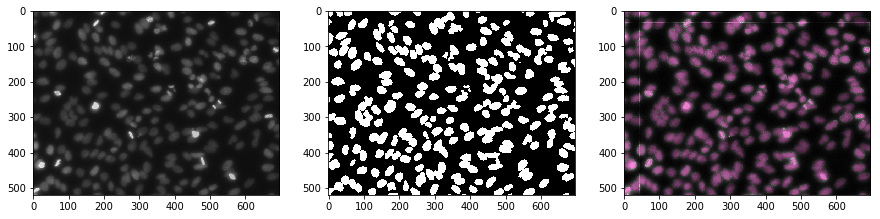

In [189]:
from skimage import color
from skimage.exposure import equalize_adapthist
from rle_utils import rle_encode, rle_decode
from tqdm import tqdm_notebook as tqdm
from skimage import color

def overlay_mask(img, mask, color_mask=None, saturation=0.9, hue=0.5): 
    img_hsv = color.rgb2hsv(
        equalize_adapthist(img)
    )
    mask_hsv = mask.copy() # black and white
    img_hsv[..., 0] = mask_hsv[..., 0] * hue
    img_hsv[..., 1] = mask_hsv[..., 1] * saturation

    if color_mask is None: 
        color_mask = mask

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[1].imshow(color_mask)
    axes[2].imshow(color.hsv2rgb(img_hsv))
    
    return fig, axes

def build_mask(img, img_mask_df): 
    all_mask_img = np.zeros_like(color.rgb2gray(img))
    
    for idx, mrow in tqdm(img_mask_df.iterrows(), total=len(img_mask_df)): 
        mask_rle = mrow['EncodedPixels']
        mask_img = rle_decode(mask_rle, (w, h))
        mask_img = mask_img.T
        all_mask_img = np.dstack([all_mask_img, mask_img]).max(axis=-1)

    return all_mask_img

def build_mask_with_channels(img, img_mask_df, num_color=7):
    all_mask_img = np.zeros((h, w, num_color))

    for idx, mrow in tqdm(img_mask_df.iterrows(), total=len(img_mask_df)): 
        mask_rle = mrow['EncodedPixels']
        mask_img = rle_decode(mask_rle, (w, h))
        random_channel = np.random.randint(num_color)
        mask_img = mask_img.T
        all_mask_img[:, :, random_channel] =  np.dstack([all_mask_img[:, :, random_channel].squeeze(), mask_img]).max(axis=-1)
    
    binary_mask = all_mask_img.max(axis=-1)
    
    return all_mask_img, binary_mask
        
row = img_labels_meta_df.sample(1).iloc[0]
img = np.array(PIL.Image.open(row['image_file']).convert('RGB'))
h, w, c = img.shape
image_id = row['ImageId']
img_mask_df = img_labels_meta_df[img_labels_meta_df['ImageId'] == image_id]

all_mask_img = build_mask(img, img_mask_df)
fig, axes = overlay_mask(img, color.gray2rgb(all_mask_img), saturation=0.46, hue=0.875)

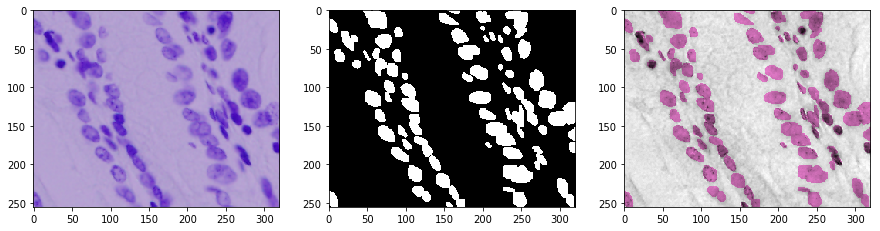

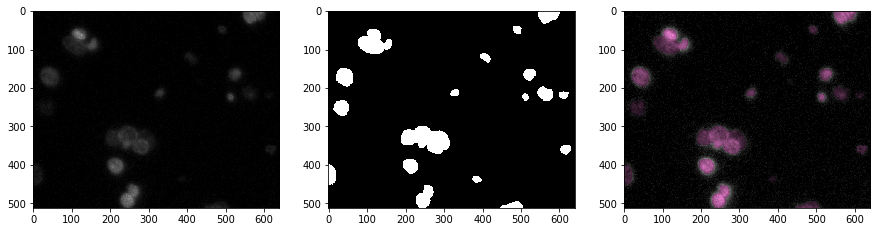

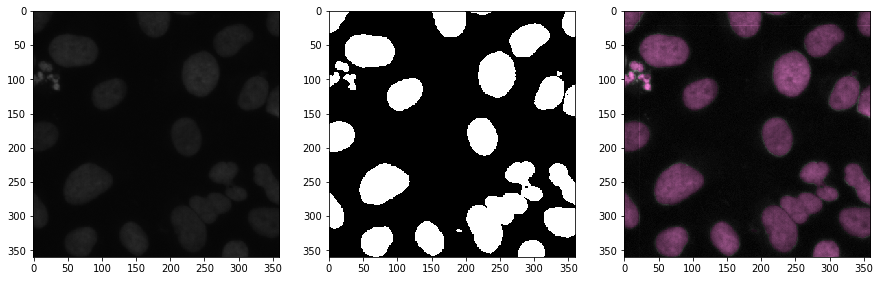

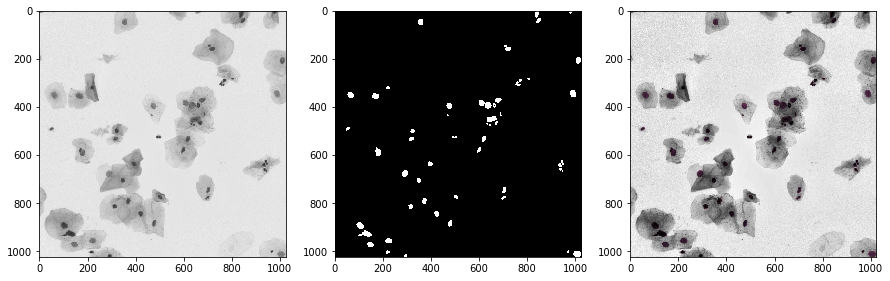

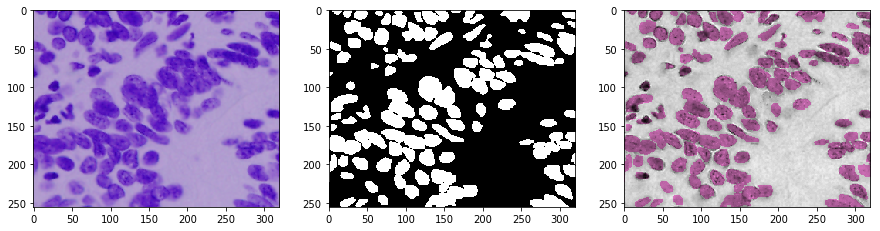

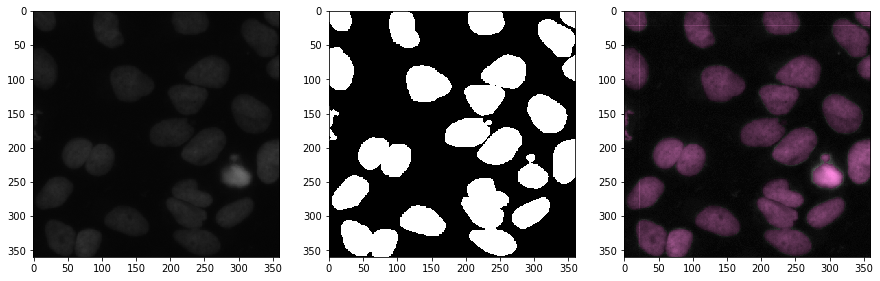

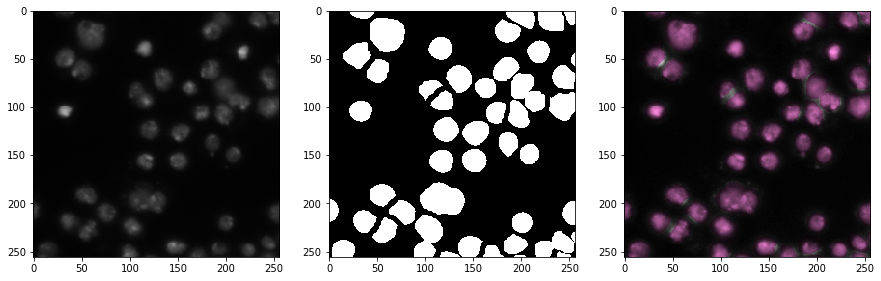

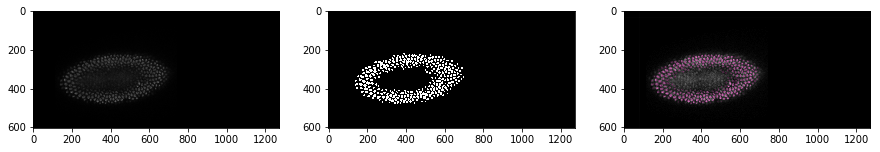

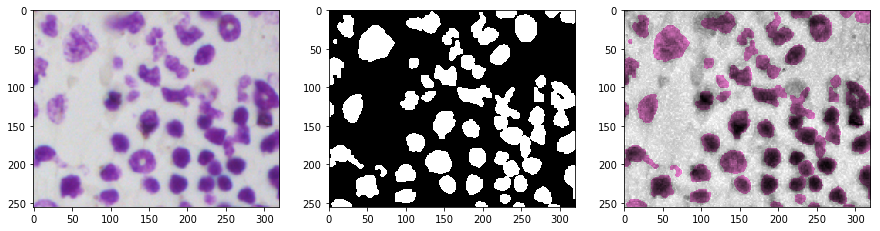

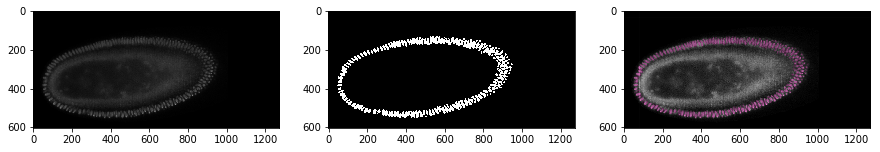

In [169]:
num_samples = 10
sampled_images_df = img_labels_meta_df.sample(num_samples)

for j, r in sampled_images_df.iterrows(): 
    img = np.array(PIL.Image.open(r['image_file']).convert('RGB'))
    h, w, c = img.shape
    image_id = r['ImageId']
    img_mask_df = img_labels_meta_df[img_labels_meta_df['ImageId'] == image_id]

    all_mask_img = build_mask(img, img_mask_df)
    fig, axes = overlay_mask(img, color.gray2rgb(all_mask_img), saturation=0.46, hue=0.875)
    plt.show()

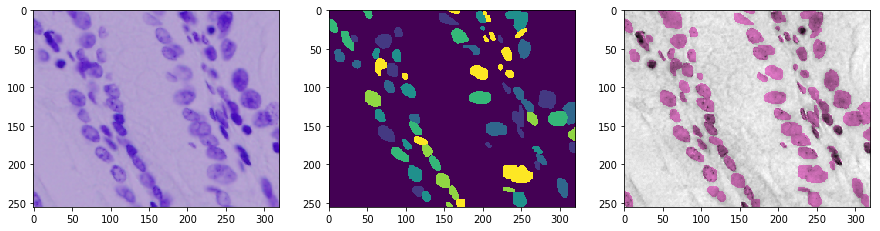

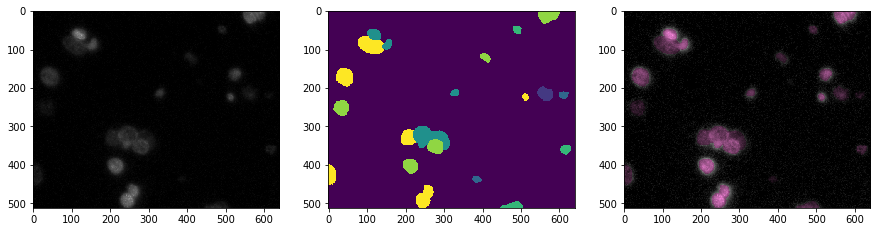

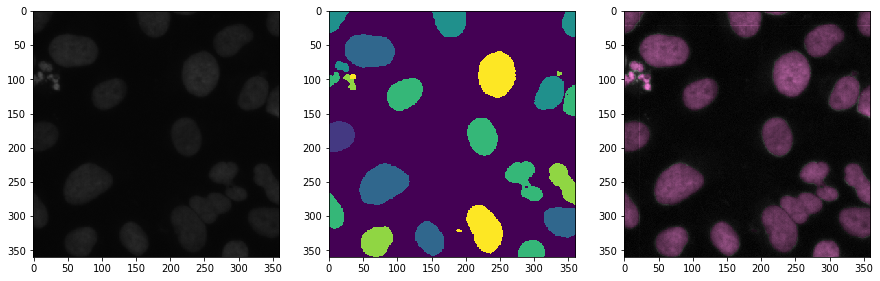

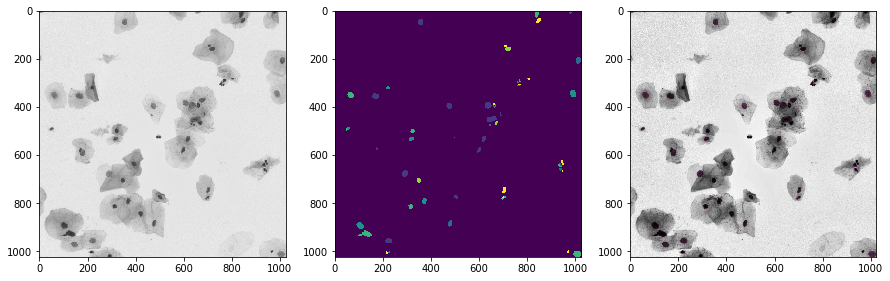

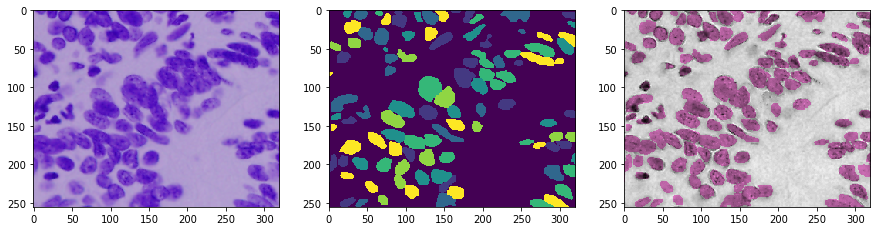

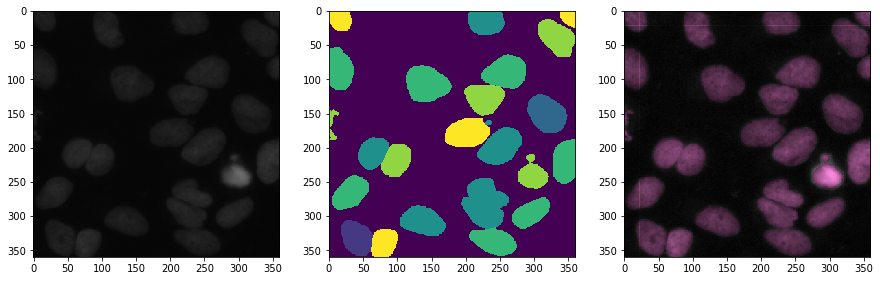

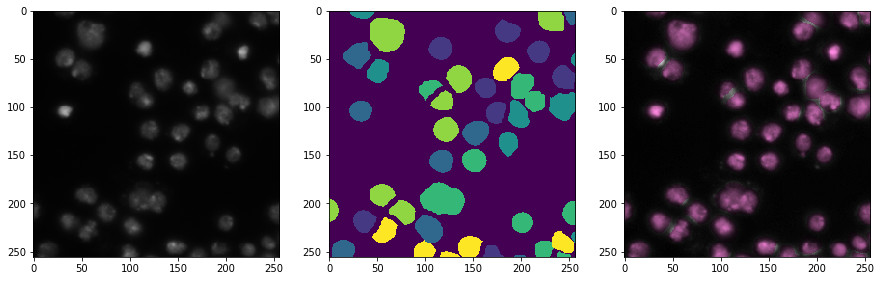

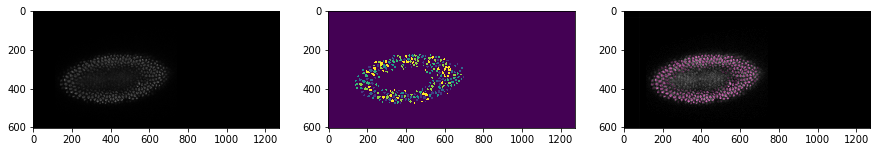

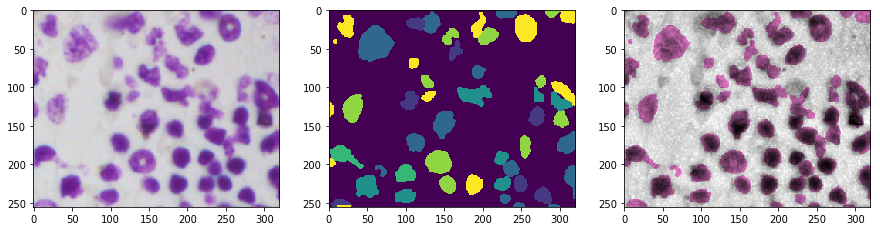

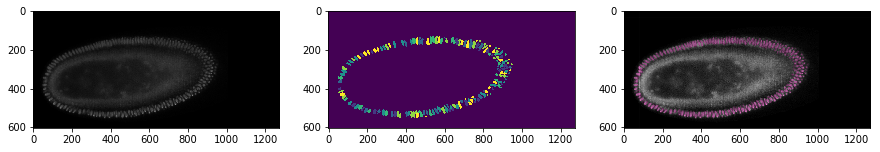

In [192]:
for j, r in sampled_images_df.iterrows(): 
    img = np.array(PIL.Image.open(r['image_file']).convert('RGB'))
    h, w, c = img.shape
    image_id = r['ImageId']
    img_mask_df = img_labels_meta_df[img_labels_meta_df['ImageId'] == image_id]
    all_mask_img, binary_mask = build_mask_with_channels(img, img_mask_df)
    
    flatten_mask_img = all_mask_img.copy()
    for ch in range(flatten_mask_img.shape[-1]): 
        flatten_mask_img[:, :, ch] = flatten_mask_img[:, :, ch]*ch
    
    fig, axes = overlay_mask(img, color.gray2rgb(binary_mask.astype(int)), color_mask=flatten_mask_img.max(axis=-1), saturation=0.46, hue=0.875)